In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from math import pi
from mpl_toolkits.axes_grid1 import ImageGrid
import scipy.stats.mstats as mstats

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


//anaconda/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pi']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


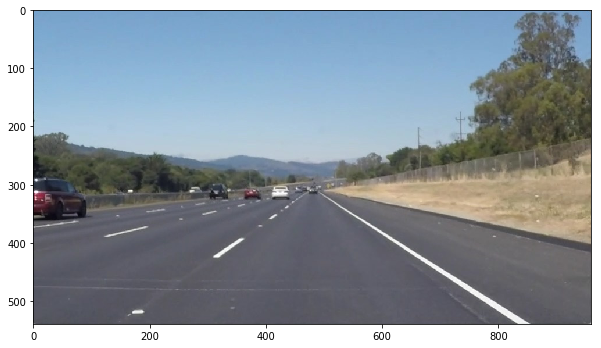

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [17]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_noise(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, left, right, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).

    Think about things like separating line segments by their
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """

    """
    What do we know about lane lines?
     - They are relatively perpendicular
     - They should exist at the same length on either side.
    """
    global prev

    if len(left) == 0 or len(right) == 0:
        return img

    # print(left)
    # print(right)
    
    left_x, left_y, left_m, left_c = lines_linreg(left)
    right_x, right_y, right_m, right_c = lines_linreg(right)

    min_y = np.min([np.min(left_y), np.min(right_y)])

    top_right_point = np.array([(min_y - right_c) / right_m, min_y], dtype=int)
    top_left_point = np.array([(min_y - left_c) / left_m, min_y], dtype=int)


    max_y = np.max([np.max(right_y), np.max(left_y)])
    bottom_left_point = np.array([(max_y - left_c) / left_m, max_y], dtype=int)
    bottom_right_point = np.array([(max_y - right_c) / right_m, max_y], dtype=int)

    cv2.line(img, (bottom_left_point[0], bottom_left_point[1]), (top_left_point[0], top_left_point[1]), [255, 0, 0], thickness)
    cv2.line(img, (bottom_right_point[0], bottom_right_point[1]), (top_right_point[0], top_right_point[1]), [255, 0, 0], thickness)
    return img


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    #line_img = np.zeros(img.shape, dtype=np.uint8)
    #draw_lines(line_img, lines)
    #return line_img
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def load_image(filename):
    return mpimg.imread('test_images/%s' % filename)

def slope_filter(lines_array, positive, min_slope, max_slope):
    slopes = np.apply_along_axis(lambda row: (row[3] - row[1]) / (row[2] - row[0]), 2, lines_array)

    if positive:
        slopes[slopes > max_slope] = 0
        slopes[slopes < min_slope] = 0
        lines_array = np.array(lines_array[np.where(slopes > 0)])
    else:
        slopes[slopes < -max_slope] = 0
        slopes[slopes > -min_slope] = 0
        lines_array = np.array(lines_array[np.where(slopes < 0)])

    return lines_array


def lines_linreg(lines_array):
    print(lines_array)
    x = np.reshape(lines_array[:, [0, 2]], (1, len(lines_array) * 2))[0]
    y = np.reshape(lines_array[:, [1, 3]], (1, len(lines_array) * 2))[0]
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y)[0]
    x = np.array(x)
    y = np.array(x * m + c)
    return x, y, m, c


def pipeline(image, verbose=False):
    img_shape = image.shape

    if verbose:
        print('Processing image.')

    width = img_shape[1]
    height = img_shape[0]
    ratio = 5/8

    roi_left = np.array([[
        (100, height),
        ((1 - ratio) * width, ratio * height),
        (.5 * width, ratio * height),
        (.5 * width, height)
    ]], dtype=np.int32)

    roi_right = np.array([[
        (.5 * width, height),
        (.5 * width, ratio * height),
        (ratio * width, ratio * height),
        (width, height)
    ]], dtype=np.int32)

    canny_low_threshold = 80
    canny_high_threshold = 200
    rho = 2  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 20  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20  # minimum number of pixels making up a line
    max_line_gap = 10  # maximum gap in pixels between connectable line segments
    gaussian_kernel = 5

    img = image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    plt.subplot(231)
    plt.imshow(img, cmap='gray')

    img = gaussian_noise(img, gaussian_kernel)
    plt.subplot(232)
    plt.imshow(img, cmap='gray')

    img = canny(img, canny_low_threshold, canny_high_threshold)
    plt.subplot(233)
    plt.imshow(img, cmap='gray')

    img = cv2.dilate(img, cv2.getStructuringElement(cv2.MORPH_DILATE, (5, 5)))

    edges_left = region_of_interest(img, [roi_left])
    edges_right = region_of_interest(img, [roi_right])

    plt.subplot(234)
    plt.imshow(edges_left, cmap='gray')

    plt.subplot(235)
    plt.imshow(edges_right, cmap='gray')

    hough_left = hough_lines(edges_left, rho, theta, threshold, min_line_length, max_line_gap)
    hough_right = hough_lines(edges_right, rho, theta, threshold, min_line_length, max_line_gap)

    if hough_left is None or hough_right is None:
        return image

    lines_left = slope_filter(hough_left, False, .5, .9)
    lines_right = slope_filter(hough_right, True, .5, .9)

    color_with_lines = np.zeros(image.shape, dtype=np.uint8)
    color_with_lines = draw_lines(color_with_lines, lines_left, lines_right, [255, 0, 0], 10)
    out = weighted_img(color_with_lines, image)

    plt.subplot(236)
    plt.imshow(out)

    if verbose:
        plt.show()
    return out

Processing image.
[[289 465 354 410]
 [278 462 349 407]
 [287 464 353 409]
 [290 465 356 412]
 [280 462 352 408]
 [278 460 346 408]
 [322 425 345 408]
 [279 460 317 431]
 [286 457 330 422]
 [280 464 310 440]
 [324 434 353 410]
 [297 460 327 436]]
[[533 337 898 539]
 [539 337 899 537]
 [528 337 878 539]
 [530 337 879 538]
 [523 337 644 406]
 [811 503 877 539]
 [573 361 694 428]
 [525 337 836 516]
 [572 356 797 485]
 [835 517 875 539]
 [673 412 891 537]
 [581 364 671 415]
 [726 440 892 535]
 [662 406 700 431]
 [532 337 596 370]
 [763 462 815 495]]


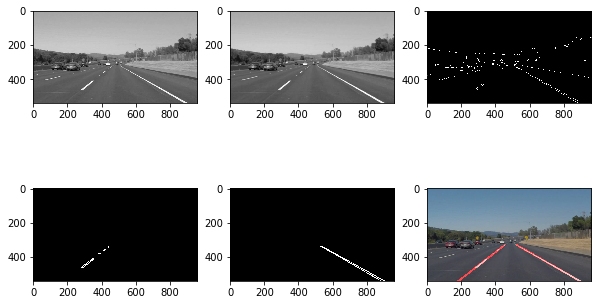

Processing image.
[[313 427 363 391]
 [309 425 359 390]
 [316 427 364 394]
 [308 423 356 390]
 [312 427 340 407]
 [310 425 362 390]
 [321 426 360 397]
 [314 427 363 392]
 [329 412 360 390]
 [308 422 334 404]
 [308 425 358 390]
 [315 427 362 394]
 [330 407 355 391]]
[[523 337 834 539]
 [530 337 854 539]
 [525 337 834 538]
 [534 337 856 538]
 [698 453 830 539]
 [528 337 852 539]
 [521 337 550 356]
 [526 337 781 496]
 [603 390 832 539]
 [611 395 649 418]
 [532 337 855 539]
 [794 504 851 539]]


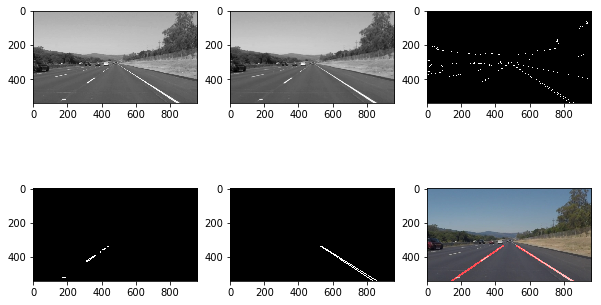

Processing image.
[[153 539 441 337]
 [174 539 378 391]
 [172 538 433 348]
 [156 539 445 337]
 [176 520 266 457]
 [223 499 444 338]
 [390 370 439 337]
 [176 539 232 498]
 [152 538 438 338]
 [173 539 387 383]
 [154 539 442 337]
 [182 530 440 342]
 [412 354 433 340]]
[[605 389 655 420]
 [609 389 660 417]
 [604 391 640 416]
 [605 391 651 421]
 [612 389 658 415]
 [607 389 658 419]
 [555 359 580 376]
 [607 391 652 421]
 [619 401 649 421]
 [606 389 635 407]
 [612 391 658 418]
 [605 390 655 421]]


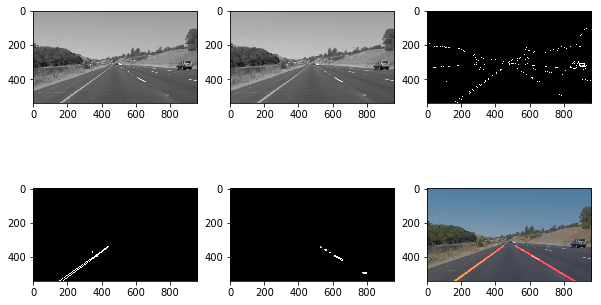

Processing image.
[[160 539 439 337]
 [177 539 445 337]
 [157 538 404 359]
 [179 539 447 337]
 [276 461 440 337]
 [162 539 418 353]
 [180 539 288 458]
 [377 379 435 339]
 [271 465 384 382]
 [158 539 244 474]
 [372 393 442 337]
 [415 352 437 337]
 [316 427 370 384]
 [161 538 212 499]
 [189 531 241 488]
 [219 496 326 416]
 [347 403 383 375]
 [323 426 410 362]
 [170 533 204 506]
 [254 478 340 415]
 [294 443 348 400]
 [398 373 444 338]]
[[708 443 875 539]
 [710 443 876 539]
 [700 445 851 539]
 [700 443 853 539]
 [698 446 845 537]
 [713 444 775 479]
 [703 442 871 539]
 [525 337 591 377]
 [539 340 593 376]
 [566 365 588 378]
 [700 449 762 487]
 [535 345 555 357]
 [572 361 592 371]
 [536 340 586 373]
 [526 337 589 378]
 [817 503 876 538]
 [537 341 590 378]
 [809 510 853 538]
 [556 350 588 374]
 [704 442 873 539]
 [704 450 802 511]
 [570 362 592 375]
 [787 497 854 538]
 [852 523 877 538]]


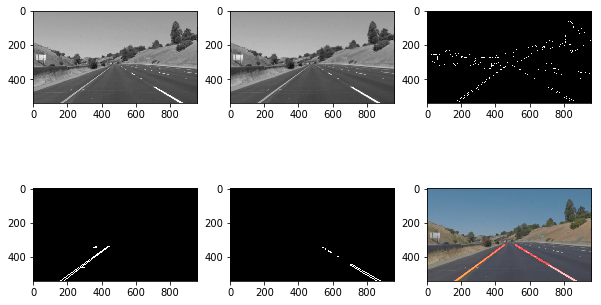

Processing image.
[[313 423 428 337]
 [158 539 436 337]
 [195 503 321 412]
 [165 523 290 433]
 [260 459 347 394]
 [212 503 420 352]
 [140 539 227 476]
 [162 538 439 337]
 [137 539 203 492]
 [295 435 350 395]
 [350 392 434 337]
 [136 539 166 517]
 [156 539 214 496]
 [263 462 430 337]
 [235 476 305 424]
 [182 523 261 462]
 [276 448 375 376]
 [304 436 431 337]
 [150 533 268 448]
 [214 499 250 475]
 [164 531 224 490]
 [346 395 438 337]
 [136 538 179 508]]
[[671 422 786 491]
 [661 422 769 495]
 [669 422 784 494]
 [661 423 768 495]
 [691 441 772 495]
 [659 425 715 462]
 [665 422 763 481]
 [557 355 580 368]
 [558 355 580 366]
 [556 357 579 369]
 [559 354 581 366]
 [560 353 580 365]
 [664 422 783 494]
 [661 424 720 465]
 [712 447 784 493]
 [752 471 785 493]
 [675 432 776 495]
 [702 452 753 486]
 [667 422 782 489]
 [659 424 687 444]]


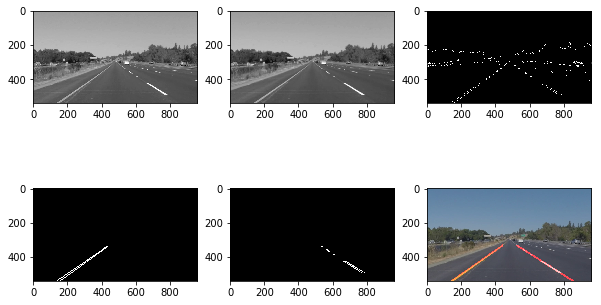

Processing image.
[[173 538 450 337]
 [177 539 270 471]
 [193 539 452 337]
 [196 539 455 337]
 [273 463 446 337]
 [192 538 444 342]
 [210 510 448 337]
 [174 538 287 458]
 [202 535 234 511]
 [353 403 406 374]
 [426 361 450 341]
 [363 396 427 360]
 [214 509 426 355]
 [196 536 258 492]
 [194 539 323 438]]
[[580 370 606 384]
 [585 366 609 381]
 [581 368 607 383]
 [743 464 856 537]
 [759 465 883 539]
 [749 462 853 524]
 [803 500 864 539]
 [741 465 819 515]
 [583 366 609 382]
 [794 495 860 539]
 [815 501 872 533]
 [579 371 600 384]
 [587 369 608 382]
 [746 462 776 480]
 [799 488 884 539]
 [742 466 790 498]
 [809 493 886 538]
 [581 371 606 385]
 [744 468 767 484]
 [826 514 862 539]
 [797 488 870 533]
 [754 463 804 496]
 [748 462 795 491]
 [787 482 818 504]
 [583 367 608 383]
 [836 520 865 538]
 [765 481 794 500]
 [776 484 804 503]
 [530 337 554 354]
 [580 369 607 384]
 [741 464 829 521]
 [777 476 806 497]]


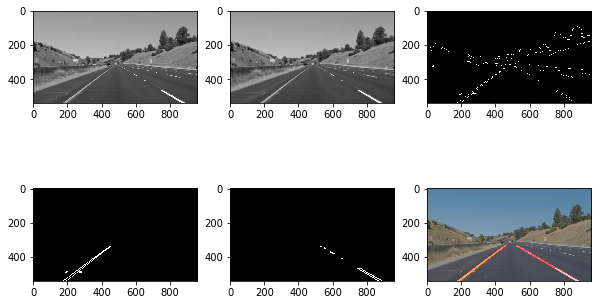

In [18]:
import os
for image in os.listdir("test_images/"):
    pipeline(load_image(image), verbose=True)
#pipeline(load_image('solidYellowLeft.jpg'))

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [6]:

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    return pipeline(image)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:25<00:00,  8.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 19.6 s, sys: 2 s, total: 21.6 s
Wall time: 26.8 s


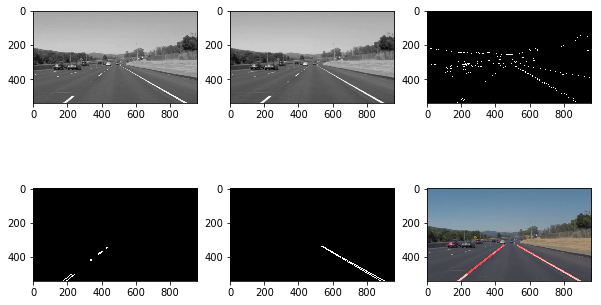

In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [01:21<00:00,  9.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 2s, sys: 5.69 s, total: 1min 8s
Wall time: 1min 23s


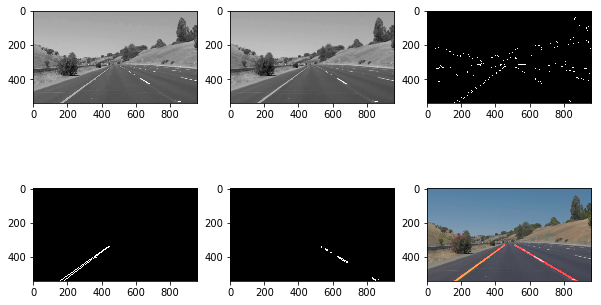

In [11]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:48<00:00,  5.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 37.9 s, sys: 4.57 s, total: 42.5 s
Wall time: 50.3 s


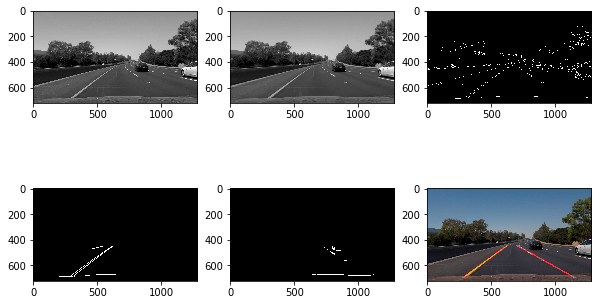

In [13]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))